# Tests

This file tests the code for the examples used to test the ADP algorithms 

In [1]:
using Plots


## simple fishery model 

In this example a deciison maker sets optimal harvest levels for a fishery with fully observed dynamics, and stochasticity. The decision maker sets the fishing mortality rate $F_t$. The popualtion dynamics are given by

$x_{t+1} = x_t e^{-m-F_t}+\frac{a x_t e^{\nu_t}}{1+bx_t}$,

where harvest levels are determined before recruitment is observed. 

Profits are given by the price $p$ time catches $x_t(1-e^{-\frac{F_t}{F_t+m}})$ times the cost $cF_t$. 

the chunks of code below plot simulations to check that the code behaves as expected.

In [2]:
include("simple_fishery.jl")

Main.simple_fishery

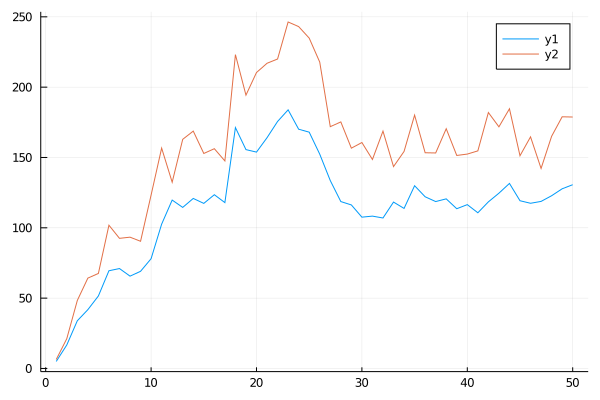

In [3]:
pars = simple_fishery.pars
xt = 5.0
f = 0.025
N = 50
x_ls = zeros(N)
pi_ls = zeros(N)
for i in 1:N
    x_ls[i] = xt
    xt, catch_ = simple_fishery.T(xt,f,pars)
    pi = simple_fishery.profit(f, catch_,pars)
    pi_ls[i] = pi 
    
end 
Plots.plot(x_ls)
Plots.plot!(pi_ls)

## Simple fishery with capital investments 
This is the same model as above but it assumes that investments can be made in harvest equipment. this reduces the cost of harvest to $\frac{c}{K_t}F_t$, where $K_t$ is the stock of capital investment. Investements car made each period $I_t$ and the standing stock of equipment $K_t$ depreciates at a rate $\Delta$. 

In [4]:
include("fishery_and_fleet.jl")

Main.fishery_and_fleet

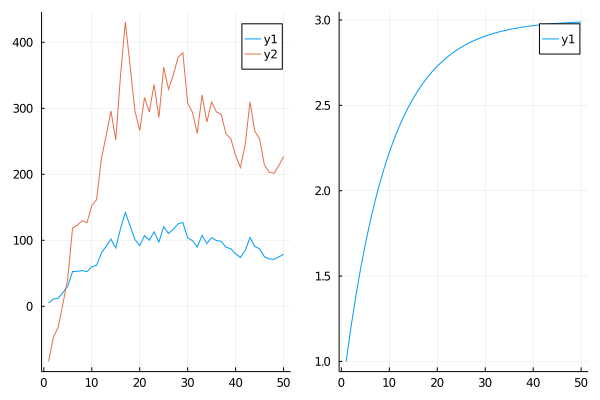

In [5]:
pars = fishery_and_fleet.pars
xt = 5.0
Kt = 1.0
s = [xt,Kt]
I = 0.3
f = 0.1
N = 50
x_ls = zeros(N)
pi_ls = zeros(N)
K_ls = zeros(N)
a = [f,I]
for i in 1:N
    x_ls[i] = s[1]
    K_ls[i] = s[2]
    pi = fishery_and_fleet.profit(s,a,pars)
    pi_ls[i] = pi 
    s = fishery_and_fleet.T(s,a,pars)
end 
p1=Plots.plot(x_ls)
Plots.plot!(pi_ls)
p2=Plots.plot(K_ls)
plot(p1,p2)

## Partially observed fishery

This model describes the dynamcis of a fishery and the beleif state of a fisheries manager. The dynamics of the fishery are the same as the first example. The manager gains informaiton by observing the catches per level of fishing effort. However, these observaitons are noisy, a number of factors effect the efficency of the fishery each season. Given this th relatiohship between catch and effort is given by 

$H = qe^{\gamma_t}Ex_t$ 

where

$\gamma_t \sim N(0,\sigma_{\gamma})$.

The manager can also choose to make an additional observaiton from an independent survey

$y_t = x_te^{\omega_t}$

where

$\omega_t \sim N(0,\sigma_{\omega})$. 

I will assume that $\sigma_{\omega} < \sigma_{\gamma}$ although this is not neccisary for $y_t$ to be informative.

### beleif state
It will be easiest to track the beleif state of the manager over the log of the popualtions abundace

$\chi_t = log(x_t)$

The beleif state will be simulated using a partical filtering algorithm and the value function will be edefined on the first $M$ moments. 

The partical filter will be initialized by importance sampling from a normal distribution matiching the first two moments and will be reweighted using hermite poynimials to adjust the dentisy function to match the higher order moments. 


In [6]:
using FastGaussQuadrature

In [7]:
FastGaussQuadrature.gausshermite(20)

([-5.387480890011233, -4.603682449550744, -3.9447640401156265, -3.3478545673832163, -2.7888060584281296, -2.2549740020892757, -1.7385377121165857, -1.2340762153953255, -0.7374737285453978, -0.24534070830090382, 0.24534070830090382, 0.7374737285453978, 1.2340762153953255, 1.7385377121165857, 2.2549740020892757, 2.7888060584281296, 3.3478545673832163, 3.9447640401156265, 4.603682449550744, 5.387480890011233], [2.2293936455341583e-13, 4.399340992273223e-10, 1.0860693707692783e-7, 7.802556478532184e-6, 0.00022833863601635774, 0.0032437733422378905, 0.024810520887463966, 0.10901720602002457, 0.28667550536283243, 0.4622436696006102, 0.4622436696006102, 0.28667550536283243, 0.10901720602002457, 0.024810520887463966, 0.0032437733422378905, 0.00022833863601635774, 7.802556478532184e-6, 1.0860693707692783e-7, 4.399340992273223e-10, 2.2293936455341583e-13])

In [575]:
include("../utils.jl")

Main.utils

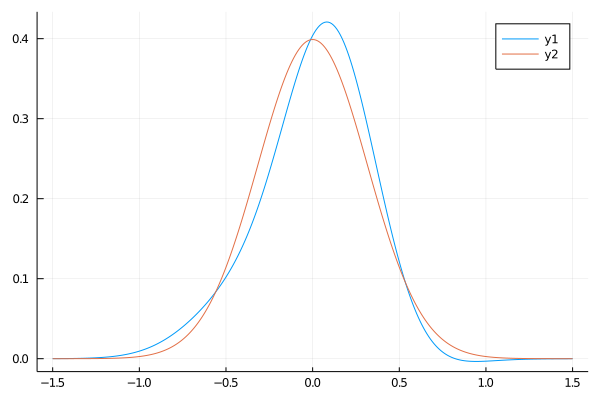

In [9]:
include("partially_observed_fishery.jl")
x = -1.5:0.01:1.5
y1 = broadcast(v -> partially_observed_fishery.dentisy_B(v,[0,0.1,-0.02,0.001]),x)
y2 = broadcast(v -> partially_observed_fishery.dentisy_B(v,[0,0.1]),x)
Plots.plot(x,y1)
Plots.plot!(x,y2)

0.09757466859294045

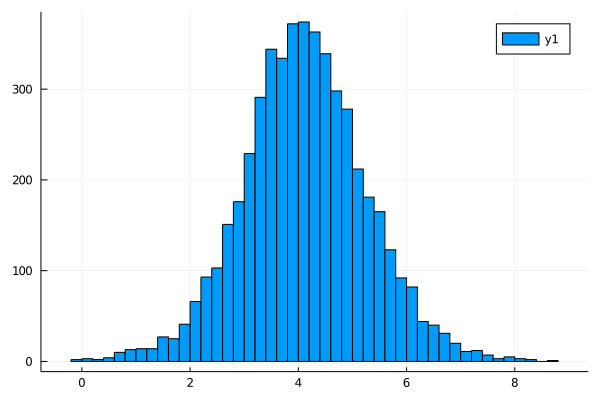

In [38]:
include("partially_observed_fishery.jl")
sample,weights = partially_observed_fishery.sample_B(5000,[4.0,2.0,-0.0,0.00])
print(utils.cumulant(partially_observed_fishery.T!(sample,0.1, partially_observed_fishery.pars), weights, 3))
#length(partially_observed_fishery.T!(sample,0.1,partially_observed_fishery.pars))
Plots.histogram(partially_observed_fishery.T!(sample,0.1,partially_observed_fishery.pars))


[5.82195541916402, 0.0878449498942698] [5.264865150331495, 0.06379820467840636] [4.957571721114341, 0.08680659634844719] 

[5.5264689192390595, 0.11970286190061027] [5.311593151304354, 0.08355673823009015] [5.643441211590261, 0.11116291446526341] 

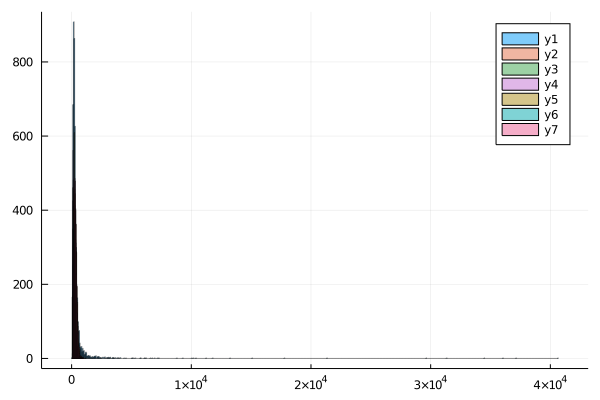

In [178]:
include("partially_observed_fishery.jl")
B = [6,0.2]
f = 0.5

samples, weights, B, log_x_t, pi = partially_observed_fishery.T_cumulants!(B,f,partially_observed_fishery.pars, 5000) 
Plots.histogram(exp.(samples), alpha = 0.5)
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)
samples, weights, B, Log_x_t, pi = partially_observed_fishery.T_samples(samples, weights, 2, f, log_x_t, partially_observed_fishery.pars) 
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)
samples, weights, B, Log_x_t, pi = partially_observed_fishery.T_samples(samples, weights, 2, f, log_x_t, partially_observed_fishery.pars) 
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)
samples, weights, B, Log_x_t, pi = partially_observed_fishery.T_samples(samples, weights, 2, f, log_x_t, partially_observed_fishery.pars) 
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)
samples, weights, B, Log_x_t, pi = partially_observed_fishery.T_samples(samples, weights, 2, f, log_x_t, partially_observed_fishery.pars) 
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)
samples, weights, B, Log_x_t, pi = partially_observed_fishery.T_samples(samples, weights, 2, f, log_x_t, partially_observed_fishery.pars) 
samples, weights = partially_observed_fishery.reweight_samples!(samples, weights)
print(B)
print(" ")
Plots.histogram!(exp.(samples), alpha = 0.5)

In [148]:
include("utils.jl")
utils.cumulant(samples,weights,2)
mu = sum(samples .* weights)
print(mu)
sqrt(sum((samples .- mu).^2 .*weights ))

3.8795960979650284

0.0752355731292719

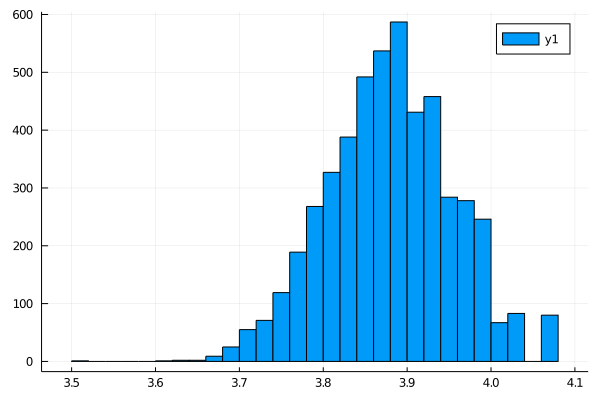

In [147]:
Plots.histogram(samples)

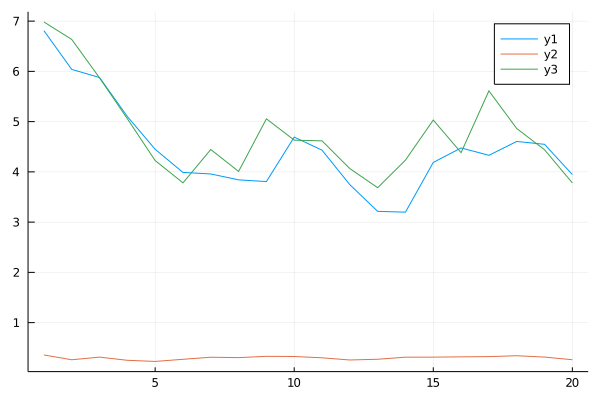

In [177]:
include("partially_observed_fishery.jl")
B = [6,3.0]
f = 0.5
B_, log_x_t_, pi_ = partially_observed_fishery.test_sim(B,f,partially_observed_fishery.pars,20, 500)
Plots.plot(B_[:,1])
Plots.plot!(sqrt.(B_[:,2]))
Plots.plot!(log_x_t_)

# Linear quadratic model

In addition to developing the traditional fisheries I have included a very simple example of a linear uadratic model. This model is useful because exact analysical solutions are avaible for the beleif dynamics, and may be for the POMDP. In the section below I include two tests of the POMP code using the linear quadratic model.  The first  plots the state and beleif dynamics of a two dimenaional linear system. The second compares the particle filter results to results from the `Kalman.jl` library.

In [542]:
include("linear_quadratic.jl")
function T!(x,c)
    return linear_quadratic.T!(x,c,linear_quadratic.pars2d)
end
function G(x,y,c)
    return linear_quadratic.G(y,x,c,linear_quadratic.pars2d)
end
function simulate_y(x)
    return linear_quadratic.simulate_y(x,linear_quadratic.pars2d)
end



simulate_y (generic function with 1 method)

In [544]:
N = 5000
prior = Distributions.MvNormal([0.0,0.0], [0.5 0; 0 0.5])
samples = rand(prior,N)
samples_ = []
for i in 1:N samples_ = vcat(samples_, [samples[:,i]]) end ;samples = samples_
weights = repeat([1.0/N],N)
POMP_ = particle_filter.POMP(samples,weights,N,G,T!)

x = rand(prior,1)

2×1 Array{Float64,2}:
  0.28281116179832266
 -0.13118109699892994

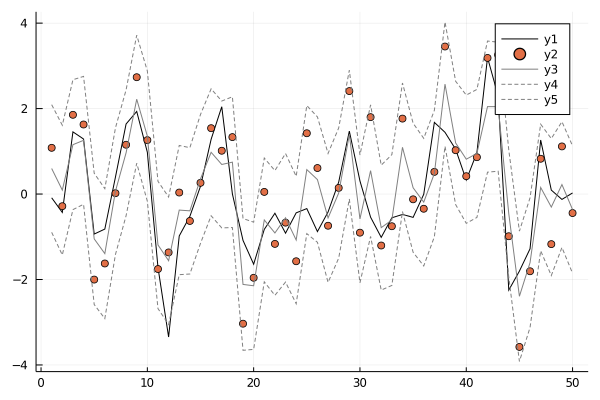

In [545]:
T_ = 50
y_ = zeros(T_)
x_ = zeros(T_)
mean_ = zeros(T_)
upper = zeros(T_)
lower = zeros(T_)
xt = x
for i in 1:T_
    xt = T!(xt,0)
    y = simulate_y(xt)
    particle_filter.filter!(POMP_,y, 0.0)
    particle_filter.reweight_samples!(POMP_)
    x_[i] = xt[1]
    y_[i] = y[1]
    mean_[i] = sum(broadcast(x -> x[1]/POMP_.N, POMP_.samples))
    sd_ = sqrt(sum(broadcast(x -> (x[1] -mean_[i])^2/POMP_.N, POMP_.samples)))
    upper[i] = mean_[i] + 2*sd_
    lower[i] = mean_[i] - 2*sd_
end 
Plots.plot(x_, color = "black")
Plots.scatter!(y_)
Plots.plot!(mean_, color = color = "grey")
Plots.plot!(upper, color = color = "grey", linestyle =:dash)
Plots.plot!(lower, color = color = "grey", linestyle =:dash)

## Kalman.jl

we can test these results by comparing the resutls of the particle filter algorithm to a known solution - the particle filter. The first block of code runs and example from the `Kalman.jl` library th following block compares these results to the sltuion produced by the particle filter. 

the restuls match for large numbers of samples in the filter, but smaller numbers perform poorly perticualrly where the observations lie far away from the expected value.  This is likely because a small number of samples recieve the majority of the weight. 

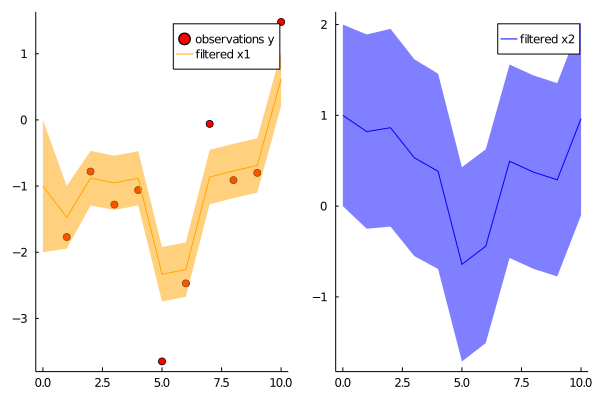

In [565]:
# using Pkg
# Pkg.add("Kalman")
# Pkg.add("GaussianDistributions")
# Pkg.add("Statistics")
using Kalman, GaussianDistributions, LinearAlgebra
using GaussianDistributions: ⊕ # independent sum of Gaussian r.v.
using Statistics

# prior for time 0
x0 = [-1., 1.]

P0 = [1.0 0; 0 1.0]

# dynamics
phi = [0.8 0.2; -0.1 0.8]
b = zeros(2)
Q = [0.2 0.0; 0.0 0.5]

# observation
H = [1.0 0.0]
R = [0.3]

# (mock) data
ys = [[-1.77], [-0.78], [-1.28], [-1.06], [-3.65], [-2.47], [-0.06], [-0.91], [-0.80], [1.48]]


# filter (assuming first observation at time 1)
N = length(ys)

p = Gaussian(x0, P0)
ps = [p] # vector of filtered Gaussians
for i in 1:N
    global p
    # predict
    p = phi*p ⊕ Gaussian(zero(x0), Q) #same as Gaussian(Φ*p.μ, Φ*p.Σ*Φ' + Q)
    # correct
    p, yres, _ = Kalman.correct(Kalman.JosephForm(), p, (Gaussian(ys[i], R), H))
    push!(ps, p) # save filtered density
end

using Plots

p1 = scatter(1:N, first.(ys), color="red", label="observations y")
plot!(p1, 0:N, [mean(p)[1] for p in ps], color="orange", 
        label="filtered x1", grid=false, ribbon=[sqrt(cov(p)[1,1]) for p in ps], fillalpha=.5)
p2 = plot(0:N, [mean(p)[2] for p in ps], color="blue", 
        label="filtered x2", grid=false, ribbon=[sqrt(cov(p)[2,2]) for p in ps], fillalpha=.5)
plot(p1,p2)

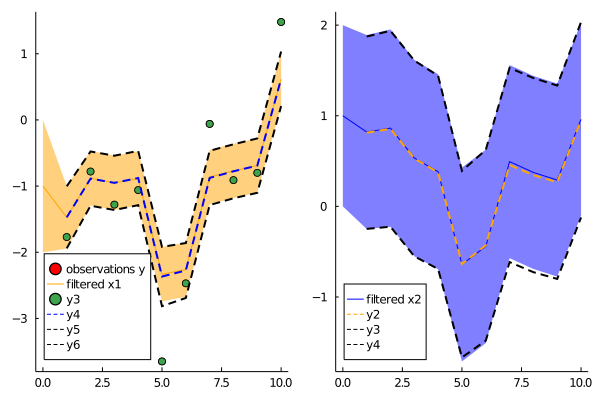

In [566]:
include("linear_quadratic.jl")
pars = (phi, H, Distributions.MvNormal(b, Q), Distributions.MvNormal([0], sqrt.(R)))

function T!(x,c)
    return linear_quadratic.T!(x,c,pars)
end
function G(x,y,c)
    return linear_quadratic.G(x,y,c,pars)
end
function simulate_y(x)
    return linear_quadratic.simulate_y(x,pars)
end

# togle N to see resutls for differnt levels of precision 
N = 50000
prior = Distributions.MvNormal(x0, P0)
samples = rand(prior,N)
samples_ = []
for i in 1:N samples_ = vcat(samples_, [samples[:,i]]) end ;samples = samples_
weights = repeat([1.0/N],N)
POMP_ = particle_filter.POMP(samples,weights,N,G,T!)


ys = [[-1.77], [-0.78], [-1.28], [-1.06], [-3.65], [-2.47], [-0.06], [-0.91], [-0.80], [1.48]]


T_ = length(ys)
y_ = zeros(T_)
x_ = zeros(T_)
mean_ = zeros(T_)
upper = zeros(T_)
lower = zeros(T_)
mean_2 = zeros(T_)
upper_2 = zeros(T_)
lower_2 = zeros(T_)
for i in 1:T_
    y = ys[i]
    particle_filter.filter!(POMP_,y, 0.0)
    particle_filter.reweight_samples!(POMP_)
    y_[i] = y[1]
    mean_[i] = sum(broadcast(x -> x[1]/POMP_.N, POMP_.samples))
    sd_ = sqrt(sum(broadcast(x -> (x[1] -mean_[i])^2/POMP_.N, POMP_.samples)))
    upper[i] = mean_[i] + sd_
    lower[i] = mean_[i] - sd_
    
    mean_2[i] = sum(broadcast(x -> x[2]/POMP_.N, POMP_.samples))
    sd_ = sqrt(sum(broadcast(x -> (x[2] -mean_2[i])^2/POMP_.N, POMP_.samples)))
    upper_2[i] = mean_2[i] + sd_
    lower_2[i] = mean_2[i] - sd_
end 
p1_ = p1
Plots.scatter!(p1_,y_)
Plots.plot!(p1_,mean_, color = color = "blue", linestyle =:dash, linewidth = 2)
Plots.plot!(p1_,upper, color = color = "black", linestyle =:dash, linewidth = 2)
Plots.plot!(p1_,lower, color = color = "black", linestyle =:dash, 
            legend = :bottomleft, linewidth = 2)

p2_ = p2
Plots.plot!(p2_,mean_2, color = color = "orange", linestyle =:dash, linewidth = 2)
Plots.plot!(p2_,upper_2, color = color = "black", linestyle =:dash, linewidth = 2)
Plots.plot!(p2_,lower_2, color = color = "black", 
            linestyle =:dash, legend = :bottomleft,
            linewidth = 2)

plot(p1_,p2_)



In [574]:
include("../POMP/tests.jl")

Main.tests